In [1]:
%load_ext autoreload
%autoreload 2
%load_ext functionizer

In [2]:
def save_fig(fig, name):
    fig.savefig(rf"C:\Users\wuyua\OneDrive - The University of Western Ontario\Research\crm\paper\figure\{name}.png", bbox_inches="tight")

In [15]:
from solvers import hr_grid_forward_step_size_independent_1d, uw_grid_forward_step_size_independent_1d, pa_forward_step, hr_grid_forward_step_size_dependent_1d, uw_grid_forward_step_size_dependent_1d
import numpy as np
from matplotlib import pyplot as plt
from time import perf_counter
from scipy.stats import norm
from scipy.integrate import trapz
from tqdm.notebook import tqdm
from scipy.stats import binned_statistic
import pandas as pd
from compress_binding import compress as compress_native
from KDEpy import FFTKDE

# Continuous single stage

In [4]:
def solubility(T):
    return 1.721e-4 * T ** 2 - 5.88e-3 * T + 0.1286

def T_profile(t):
    return 32-4*(1-np.exp(-t/18600))

def birth_rate(T, c, v):
    kb = 4.64e-7 * 1000
    b = 1.78
    sol = solubility(T)
    if c > sol:
        B = kb * ((c - sol) / sol) ** b
    else:
        B = 0.
    return B

def growth_rate(T, c, L, beta=0.):
    kg = 1.16e2
    g = 1.32
    sol = solubility(T)
    G = kg * ((c - sol) / sol) ** g * (1 + beta*L)
    return G

density = 2.11e-12 # g/um3

dL = 0.5
L_edges = np.arange(0, 1000, dL)
L_centers = 0.5 * (L_edges[1:] + L_edges[:-1])
n_init = np.zeros_like(L_centers)
non_zero_idx = (L_centers >= 180.5) & (L_centers <= 210.5)
L_non_zero = L_centers[non_zero_idx]
n_init[non_zero_idx] = -3.48e-4 * L_non_zero ** 2 + 0.136 * L_non_zero - 13.21
T_init = T_profile(0)
c_init = solubility(T_init)
v_init = trapz(n_init * L_centers ** 3, L_centers)

In [5]:
growth_fcn = hr_grid_forward_step_size_dependent_1d
residence_time = 100
t_total = 3000
T = 25
time_step_scale = 0.5

dt_max = 1
beta = 0.01

# Solving with grid method

In [6]:
%%functionize single_stage_simulation -a growth_fcn beta time_step_scale -r ts cs vs cnts n --skip
n = n_init.copy()
# n = np.zeros_like(n_init)

c = c_init

v = trapz(n * L_centers**3, L_centers)

t = 0
pbar = tqdm(total=t_total, desc="single stage")

cs = [c]
ts =[t]
vs = [v]
cnts = [trapz(n, L_centers)]

while t < t_total:
    G = growth_rate(T, c, L_centers, beta)
    B = birth_rate(T, c, v)


    # compute time step
    dt = dL / np.max(G)
    dt = np.min([dt, dt_max]) * time_step_scale
    dt = np.min([dt, t_total-t])
    # Update nucleation
    n[0] += B * dt / dL

    # Update growth
    n = growth_fcn(n, dL, dt, G)

    # Update concentration
    v_new = trapz(n * L_centers ** 3, L_centers)
    c -= (v_new - v) * density
    v = v_new

    # Update continuous
    c_in = c_init
    n_in = 0

    c += (c_in - c) * dt / residence_time
    n += (n_in - n) * dt / residence_time

    t += dt
    pbar.update(dt)

    ts.append(t)
    cs.append(c)
    vs.append(v)
    cnts.append(trapz(n, L_centers))

pbar.close()

In [8]:
ts_hr_neg, cs_hr_neg, vs_hr_neg, cnts_hr_neg, n_hr_neg = single_stage_simulation(hr_grid_forward_step_size_dependent_1d, -0.0005, time_step_scale)
ts_uw, cs_uw, vs_uw, cnts_uw, n_uw = single_stage_simulation(uw_grid_forward_step_size_dependent_1d, 0.0005, time_step_scale)
ts_hr, cs_hr, vs_hr, cnts_hr, n_hr = single_stage_simulation(hr_grid_forward_step_size_dependent_1d, 0.0005, time_step_scale)

ts_hr_ind, cs_hr_ind, vs_hr_ind, cnts_hr_ind, n_hr_ind = single_stage_simulation(hr_grid_forward_step_size_dependent_1d, 0., time_step_scale)

single stage:   0%|          | 0/3000 [00:00<?, ?it/s]

single stage:   0%|          | 0/3000 [00:00<?, ?it/s]

single stage:   0%|          | 0/3000 [00:00<?, ?it/s]

single stage:   0%|          | 0/3000 [00:00<?, ?it/s]

# Solving with PA

In [79]:
%%functionize single_stage_simulation_pac -a beta time_step_scale -r ts_pac cs_pac vs_pac cnt_pac N_pac --skip

# PAC
n_pac = n_init.copy()
N_pac = np.vstack([L_centers, n_pac * dL]).T
N_pac = N_pac[N_pac[:, -1] > 0]
t = 0.

pbar = tqdm(total=t_total, desc="PAC")
c = c_init
v = (N_pac[:, 0] ** 3 * N_pac[:, -1]).sum()
cs_pac = [c]
ts_pac =[t]
vs_pac = [v]
cnt_pac = [N_pac[:, -1].sum()]

while t < t_total:
    
    G = growth_rate(T, c, N_pac[:, 0], beta)
    B = birth_rate(T, c, v)
    
    # compute time step
    dt = dL / np.max(G) * time_step_scale
    dt = np.min([dt, dt_max])
    dt = np.min([dt, t_total-t])
    dt = np.max([dt, 0.1])
#     dt =0.05##################
    
    # Update nucleation
    if B != 0:
        N_pac = np.vstack([N_pac, np.array([0, B * dt])])

        # recalculate due to the new row
        G = growth_rate(T, c, N_pac[:, 0], beta)
    
    # Update growth
    # N_pa = pa_forward_step(N_pa, dt, np.expand_dims(G, 1))
    N_pac[:, 0] += G * dt
    # Update concentration
    v_new = (N_pac[:, 0] ** 3 * N_pac[:, -1]).sum()
    c -= (v_new - v) * density
    v = v_new
    
    # Update continuous
    c_in = c_init

    c += (c_in - c) * dt / residence_time
    N_pac[:, -1] += -N_pac[:, -1] * dt / residence_time
    
#     if N_pac.shape[0] > 10000:
#         N_pac = compress_native(N_pac, 5.0, np.array([3.0]), 1.0, False)
        
#     N_pac = N_pac[N_pac[:, 0] < 1000] # remove out of grid objects
#     N_pac = N_pac[N_pac[:, -1] > 1e-10]
    t += dt
    pbar.update(dt)
    
    ts_pac.append(t)
    cs_pac.append(c)
    vs_pac.append(v)
    
    cnt_pac.append(N_pac[:, -1].sum())

pbar.close()


In [60]:
pac_indep = single_stage_simulation_pac(0., time_step_scale * 3)
pac_neg = single_stage_simulation_pac(-0.0005, time_step_scale * 3)

PAC:   0%|          | 0/3000 [00:00<?, ?it/s]

PAC:   0%|          | 0/3000 [00:00<?, ?it/s]

PAC:   0%|          | 0/3000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [80]:
pac_pos = single_stage_simulation_pac(0.0005, time_step_scale)

PAC:   0%|          | 0/3000 [00:00<?, ?it/s]

## Visualization

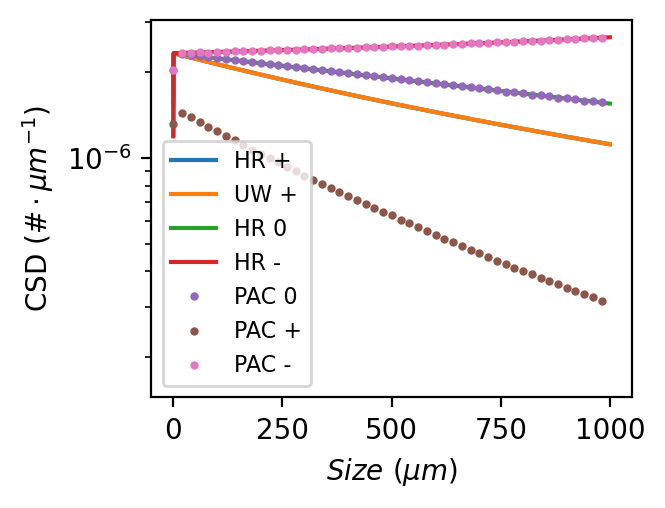

In [81]:
def get_kde_xy(N, grid, bw=2.0, kernel="epa", filter_range=None):
    kde = FFTKDE(bw=bw, kernel=kernel)
    low_bound = 0
    if filter_range is not None:
        N = N[N[:, 0] < filter_range]
        
    data = N[:, 0]
    data = np.concatenate((data, 2 * low_bound - data))
    weight = np.concatenate((N[:, 1], N[:, 1]))
    kde.fit(data, weight)
    x = grid
    y = kde.evaluate(grid)
    y = y*2* N[:, -1].sum()
    idx = x > 0
    x = x[idx]
    y = y[idx]
    return x, y

plot_range = 1000
grid_point = np.linspace(-plot_range, plot_range, 3000)
pac_indep_x, pac_indep_y = get_kde_xy(pac_indep[-1], grid_point, filter_range=plot_range)
pac_neg_x, pac_neg_y = get_kde_xy(pac_neg[-1], grid_point, filter_range=plot_range)
pac_pos_x, pac_pos_y = get_kde_xy(pac_pos[-1], grid_point, filter_range=plot_range)

fig, ax = plt.subplots(figsize=(3.1, 2.5), dpi=200)

lim = L_centers < plot_range

ax.plot(L_centers[lim], n_hr[lim], label="HR +")
ax.plot(L_centers[lim], n_uw[lim], label="UW +")
ax.plot(L_centers[lim], n_hr_ind[lim], label="HR 0")
ax.plot(L_centers[lim], n_hr_neg[lim], label="HR -")

ms = 4
ax.plot(pac_indep_x, pac_indep_y, ".", ms=ms, label="PAC 0", markevery=30)
ax.plot(pac_pos_x, pac_pos_y, ".", ms=ms, label="PAC +", markevery=30)
ax.plot(pac_neg_x, pac_neg_y, ".", ms=ms, label="PAC -", markevery=30)
# ax.plot(centers, nd, ".", markevery=1)
ax.set_xlabel("$Size\ (\mu m)$")
ax.set_ylabel("CSD $(\#\cdot \mu m^{-1})$")
ax.legend(fontsize=8)
# ax.set_xscale("log")
ax.set_yscale("log")


In [76]:
save_fig(fig, "continuous_final_csd")

In [82]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(pac_indep_x.reshape(-1, 1), np.log10(pac_indep_y.reshape(-1, 1)))
print(f"B={model.intercept_}")
print(f"K={model.coef_}")

B=[-5.63195184]
K=[[-0.00017893]]


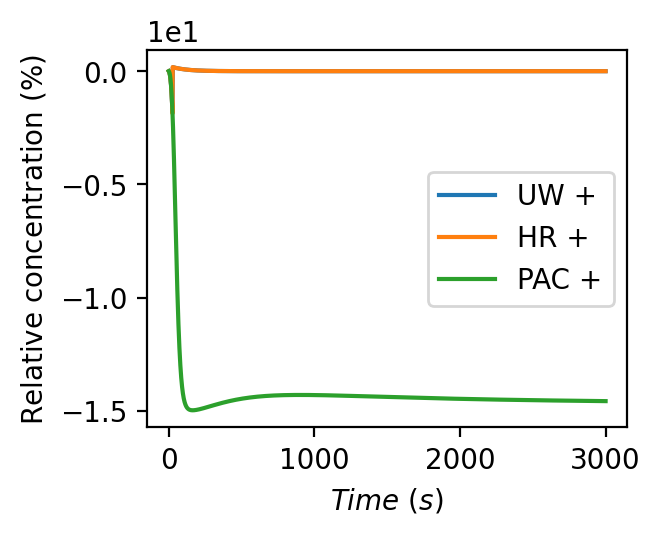

In [83]:
fig, ax = plt.subplots(figsize=(3.1, 2.5), dpi=200)

def make_relative_conc(conc):
    return (conc - conc[0])/conc[0] * 100
ax.plot(ts_uw, make_relative_conc(cs_uw), label="UW +")
ax.plot(ts_hr, make_relative_conc(cs_hr), label="HR +")
ax.plot(pac_pos[0], make_relative_conc(pac_pos[1]), label="PAC +")
ax.set_xlabel("$Time\ (s)$")
ax.set_ylabel("Relative concentration $(\%)$")
ax.ticklabel_format(axis="y", style="sci", scilimits=(-1, 1))
ax.legend()

In [277]:
save_fig(fig, "continuous_relative_concentration_profile")

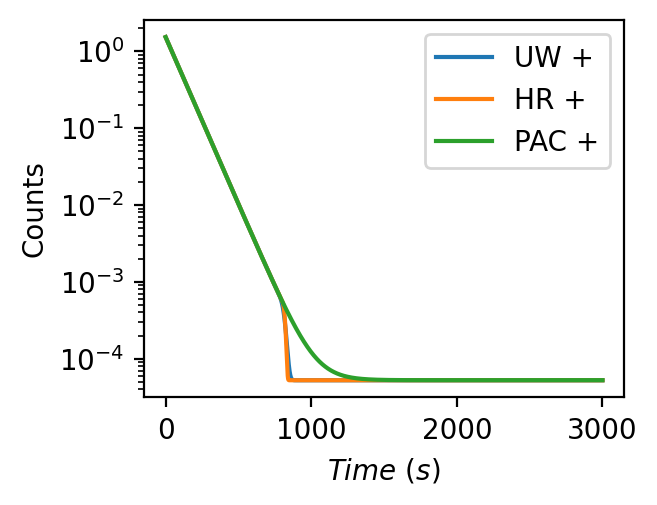

In [278]:
fig, ax = plt.subplots(figsize=(3.1, 2.5), dpi=200)

ax.plot(ts_uw, cnts_uw, label="UW +")
ax.plot(ts_hr, cnts_hr, label="HR +")
ax.plot(pac_pos[0], pac_pos[3], label="PAC +")
ax.set_xlabel("$Time\ (s)$")
ax.set_ylabel("Counts")
ax.ticklabel_format(axis="y", style="sci", scilimits=(-1, 1))
ax.legend()
ax.set_yscale("log")

In [279]:
save_fig(fig, "continuous_counts_profile")

## Case study: higher time step coefficient does not affect the accuracy too much

In [46]:
def kde_auto_bw(N, grid, filter_range, bw_step = 0.05, bw_start = 0.2, bw_max=20., rolling_window=10, rtol=0.0005, data_scale=1e6):
    # searching for the optimal bw
    bw = bw_start
    std = 1e10
    while bw <= bw_max:
        x, y = get_kde_xy(N, grid, filter_range=filter_range, bw=bw)
        bw += bw_step
        std_new = pd.Series(y*data_scale).rolling(rolling_window).std().mean()
        rdiff = (std_new - std)/std
        if np.abs(rdiff) < rtol:
            return x, y, bw
        std = std_new
    raise ValueError("Failed to find a proper bw")
    

In [47]:
ys = []
case_study_scales = [1.0, 2.0, 5.0, 10.0]
bws = []
for scale in case_study_scales:
    pac_case_study = single_stage_simulation_pac(0., scale)
    
    plot_range = 520
    grid_point = np.linspace(-plot_range, plot_range, 3000)
    pac_case_study_x, pac_case_study_y, bw = kde_auto_bw(pac_case_study[-1], grid_point, filter_range=plot_range)
    
    used_range = (pac_case_study_x >= 1) & (pac_case_study_x <= 300)
    pac_case_study_x = pac_case_study_x[used_range]
    pac_case_study_y = pac_case_study_y[used_range]
    bws.append(bw)
    ys.append(pac_case_study_y)

PAC:   0%|          | 0/1000 [00:00<?, ?it/s]

PAC:   0%|          | 0/1000 [00:00<?, ?it/s]

PAC:   0%|          | 0/1000 [00:00<?, ?it/s]

PAC:   0%|          | 0/1000 [00:00<?, ?it/s]

In [48]:
from scipy.interpolate import interp1d
relative_diff = []
relative_diff_subrange = []
for y in ys:
    interp = interp1d(L_centers, n_hr_ind, kind="linear", fill_value="extrapolate")
    ref_y = interp(pac_case_study_x)
    relative_diff.append(((ref_y - y) / ref_y).mean())
    
    rg = pac_case_study_x > 100
    relative_diff_subrange.append(((ref_y[rg] - y[rg]) / ref_y[rg]).mean())

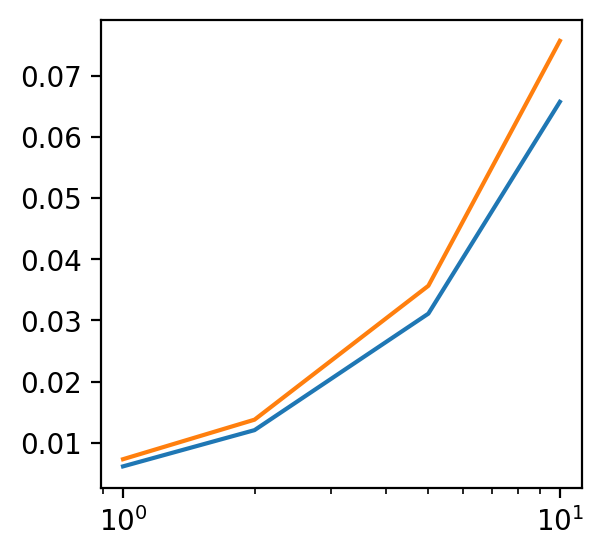

In [49]:
fig, ax = plt.subplots(figsize=(3.1, 3.1), dpi=200)

ax.plot(case_study_scales, relative_diff)
ax.plot(case_study_scales, relative_diff_subrange)
ax.set_xscale("log")

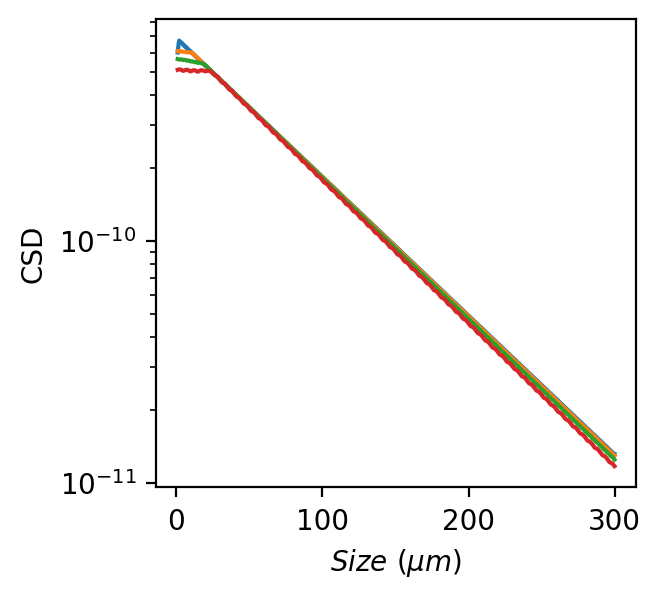

In [50]:
plot_range = 520


fig, ax = plt.subplots(figsize=(3.1, 3.1), dpi=200)

for y in ys:
    ax.plot(pac_case_study_x, y)

ax.set_xlabel("$Size\ (\mu m)$")
ax.set_ylabel("CSD")
# ax.legend(fontsize=8)
# ax.set_xscale("log")
ax.set_yscale("log")
